Solve the Navier-Stokes equation on a square domain.  That is, find $p,\mathbf{v}:\Omega \rightarrow \Re \times \Re^n$ such that
$$
\nabla \cdot \mathbf{v}  = r(x,t) 
$$
$$
\frac{\partial \mathbf{v}}{\partial t} + \nabla\cdot\left(\mathbf{v}\otimes\mathbf{v}\right) +  \nabla p  - \nabla \cdot \left(\frac{1}{Re}\nabla  \mathbf{v}\right) = \mathbf{f}(x,t)
$$
on 
$$
\Omega = [0,1]
$$
 where $r(x,t)$ is a function of space and time only, $\mathbf{f}(x,t)$ and the Reynolds number, $Re$, is a constant. 
 
To be complete and solvable we add in dirichlet boundary conditions on $p(x,t)$ and inflow boundary conditions on velocity $v(x,t)$,  (this means we set the diffusive bc = 0 and advective bc = None to allow for the inflow bc to happen)
$$
\left.p\right|_{\partial\Omega} = p(x,t)
$$
and for $\partial\Omega^{in} = \{ x \:|\: v(x,t)\cdot n < 0\}$ we have inflow in which case we set
$$
\left.v\right|_{\partial\Omega^{in}} = v(x,t). 
$$
Finally we need initial conditions
$$
u(x,t=0) = u_0(x), \hspace{1cm} p(x,t=0) = p_0(x).
$$

In [2]:
from proteus.iproteus import * #pull in what we need for using proteus interactively
Profiling.logLevel=3
Profiling.verbose = True

Define the PDE by defining the coefficients

In [3]:
class NavierStokes1D(TransportCoefficients.TC_base):
    """
    The coefficients of the Poisson equation 
    """
    def __init__(self,rofx,fofx,Re=1.0):
        TransportCoefficients.TC_base.__init__(self, 
                         nc=2, #number of components
                         variableNames=['p','v'],
                         mass = {1:{1:'linear'}}, # du/dt
                         advection = {0:{1:'linear'}, # \nabla\cdot v
                                      1:{1:'nonlinear'}}, # \nabla \cdot (v\otimes v)
                         hamiltonian = {1:{0:'linear'}}, # grad (p)
                         diffusion = {1:{1:{1:'constant'}}}, # - 1/Re * \grad v
                         potential = {1:{1:'u'}}, # define the potential for the diffusion term to be the solution itself
                         reaction  = {0:{0:'constant'}, # r(x)
                                      1:{1:'constant'}}) # f(x)
        self.rofx=rofx
        self.fofx=fofx
        self.Re=Re
        
    def evaluate(self,t,c):
        """
        evaluate quadrature point values held in the dictionary c
        These are labelled according to the 'master equation.' For example,
         
        c[('a',0,0)] = diffusion coefficient for the 0th equation (first) with respect to the
                       0th potential (the solution itself)
                       The value at each quadrature point is a n_d x n_d tensor (n_d=number of space dimensions).
                       Usually the tensor values are stored as a flat array in compressed sparse row format to save space. 
                       By default, we assume the tensor is full though.
                       
        c[('r',0)]   = reaction term for the 0th equation. This is where we will put the source term
        """
        p = c[('u',0)]
        v = c[('u',1)] #1D - x component of velocity
        grad_p = c[('grad(u)',0)]
        #equation 0  div(f) + r = 0  (proteus  notation)  div(velocity)=r(x) (our notation)
        c[('f',0)][...,0] = v
        c[('df',0,1)][...,0] = 1.0  # d_f^0_d_u^0
        c[('r',0)][:]     = -self.rofx(c['x'][:],t)
        c[('dr',0,0)][:]   = 0.0
        #equation 1   A grad(p) + v + div(-epsilon grad(v)) = 0
        c[('m',1)][:] = v  # d/dt ( 1.0 * v) = d/dt (m_1)
        c[('dm',1,1)][:] = 1.0  # d_m^1_d_u^1
        c[('f',1)][...,0] = v*v # div ( v\otimes v)
        c[('df',1,1)][...,0] = 2*v # d_f^1_d_u^1
        c[('H',1)][:] = grad_p[...,0] #grad(p)
        c[('dH',1,0)][...,0] = 1.0 # 1
        c[('r',1)][:]     = -self.fofx(c['x'][:],t)
        c[('dr',1,1)][:]  = 0.0#0
        c[('a',1,1)][...,0] = 1.0/self.Re # -1/Re * \grad v
        c[('da',1,1,1)][...,0] = 0.0 # -d_(1/Re)




Setup the problem to have a solution

$$
p(x,t) = 1 + \sin(2\pi (x-t))
$$

and

$$
v(x,t) = \sin(2\pi(x-t))\cos(2\pi(x-t))
$$

thus

$$
r(x,t) = \nabla\cdot v = 2\pi\cos(4\pi(x-t))
$$
and

$$
f(x,t) = 2\pi\left[\sin(2\pi(x-t))\cos(2\pi(x-t)) - 1\right]\cos(4\pi(x-t)) + 2\pi\cos(2\pi(x-t)) + \frac{8\pi^2}{Re}\sin(4\pi(x-t))
$$

Note that we are not divergence free here in 1D since that would require constant velocity.  The momentum equation must be written in the form  $\nabla\cdot(v\otimes v)$  instead of $v\cdot\nabla v$ since the second form utilizes the fact that $v$ is divergence free.

Define the python functions for evaluating the terms. Note that the x array for the quadrature points will be a

multidimensional array. The last dimension will be 3 always though.

In [4]:
#use numpy for evaluations
import numpy as np

# Reynolds number
Re = 1.0

def pex0(x,t):
    pi2=2.0*np.pi    
    return 1.0 + np.sin(pi2*(x[...,0]-t))

def vex0(x,t):
    pi2=2.0*np.pi
    return np.cos(pi2*(x[...,0]-t))*np.sin(pi2*(x[...,0]-t))

def rofx0(x,t):
    pi2=2.0*np.pi
    return 2.0*pi2*np.cos(pi2*(x[...,0]-t))

def fofx0(x,t):
    pi2=2.0*np.pi
    pi4=2.0*pi2
    return pi2*(np.cos(pi2*(x[...,0]-t))*np.sin(pi2*(x[...,0]-t))-1)*np.cos(pi4*(x[...,0]-t)) \
           + pi2*np.cos(pi2*(x[...,0]-t)) + pi2*pi4/Re*np.sin(pi4*(x[...,0]-t))

Define the physical input to the model

In [5]:
#use numpy for evaluations
import numpy as np
physics = default_p
physics.name = "navier_stokes_1d"
physics.nd = 1; #One dimension
#spatial domain
physics.L=(1.0,1.0,1.0)

# Integrate from t=0 to t=1
physics.T = 1.0

#the object for evaluating the coefficients   
physics.coefficients=NavierStokes1D(rofx0,fofx0,Re)

#this functions job is to return another function holding the Dirichlet boundary conditions 
# wherever they are set
    
eps=1.0e-8
boundaryFlags = {'left':1,'right':2,'top':3}
def getDBC_p(x,flag):
    if x[0] <= 0.0+eps:
        return lambda x,t: pex0(x,t)
    elif x[0] >= physics.L[0]-eps:
        return lambda x,t: pex0(x,t)
    else:
        return None
    
def getDBC_v(x,flag):
    if x[0] <= 0.0+eps:
        return lambda x,t: vex0(x,t)
    elif x[0] >= physics.L[0]-eps:
        return lambda x,t: vex0(x,t)
    else:
        return None
    
def getNone(x,flag):
    return None

def getZeroFlux(x,flag):
    if x[0] <= 0.0+eps:
        return lambda x,t: 0.0
    elif x[0] >= physics.L[0]-eps:
        return lambda x,t: 0.0
    else:
        return None
    
class getIBC_p:
    def __init__(self):
        self.pex0=pex0
        pass
    def uOfXT(self,x,t):
        return self.pex0(x,t)

    
class getIBC_v:
    def __init__(self):
        self.vex0=vex0
        pass
    def uOfXT(self,x,t):
        return self.vex0(x,t)
    
physics.initialConditions = {0:getIBC_p(),
                             1:getIBC_v()}

physics.dirichletConditions = {0:getDBC_p,#pressure Dirichlet
                               1:getDBC_v}

physics.advectiveFluxBoundaryConditions = {0:getNone}#dummy condition for non-existent  advective flux
#there are no diffusion terms in this model, but I had to 
physics.diffusiveFluxBoundaryConditions = {1:{1:getZeroFlux}}#viscous flux
physics.fluxBoundaryConditions = {0:'mixedFlow',1:'outFlow'}

Define the numerics input for the problem

In [6]:
numerics=default_n
#piecewise linears
numerics.femSpaces = {0:FemTools.C0_AffineLinearOnSimplexWithNodalBasis,#pressure space
                      1:FemTools.C0_AffineQuadraticOnSimplexWithNodalBasis}#velocity space

numerics.timeIntegration = TimeIntegration.BackwardEuler
numerics.DT = 0.01
numerics.tnList = list(np.arange(0.0,physics.T+numerics.DT,numerics.DT))
# numerics.nDTout=10

#Quadrature rules for elements and element  boundaries
numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd,4)
numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1,4)
#number of nodes in the x and y direction
numerics.nn = 101
#numerics.nny= 41
#matrix type
numerics.numericalFluxType = NumericalFlux.StrongDirichletFactory(physics.fluxBoundaryConditions)
#numerics.numericalFluxType = MixedDarcy_exterior
#numerics.numericalFluxType = NumericalFlux.Advection_DiagonalUpwind_Diffusion_IIPG_exterior
#numerics.numericalFluxType = NumericalFlux.Advection_Diagonal_average
numerics.matrix = LinearAlgebraTools.SparseMatrix
#use petsc solvers wrapped by petsc4py
#numerics.multilevelLinearSolver = LinearSolvers.KSP_petsc4py
#numerics.levelLinearSolver = LinearSolvers.KSP_petsc4py
#using petsc4py requires weak boundary condition enforcement
#can also use our internal wrapper for SuperLU
# numerics.multilevelLinearSolver = LinearSolvers.KSP_petsc4py
numerics.levelLinearSolver = LinearSolvers.LU

# numerics.multilevelNonlinearSolver = NonlinearSolvers.Newton
numerics.levelNonlinearSolver = NonlinearSolvers.Newton

#linear solve rtolerance
numerics.l_atol_res = 1.0e-8
numerics.nl_atol_res = 1.0e-8
numerics.periodicDirichletConditions=None
#
# split operator options (trivial since we're not splitting)
#
so = default_so
so.name = physics.name
so.sList=[default_s]
so.tnList = numerics.tnList

Construct a NumericalSolution object and solve the problem

In [7]:
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
ns.calculateSolution('run1')
#arrays for using matplotlib's unstructured plotting interface
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
#y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
#triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray


# grab the last time step solution and save the components as pT and vT
pT = ns.modelList[0].levelModelList[-1].u[0].dof
vT = ns.modelList[0].levelModelList[-1].u[1].dof

[       0] Initializing NumericalSolution for navier_stokes_1d
 System includes: 
navier_stokes_1d

[       0] Setting Archiver(s)
[       0] Setting up MultilevelMesh
[       0] Building one multilevel mesh for all models
[       0] Generating mesh for navier_stokes_1d
[       0] Partitioning mesh among 1 processors using partitioningType = 0
[       0] Number of Subdomain Elements Owned= 100
[       0] Number of Subdomain Elements = 100
[       0] Number of Subdomain Nodes Owned= 101
[       0] Number of Subdomain Nodes = 101
[       0] Number of Subdomain elementBoundaries Owned= 101
[       0] Number of Subdomain elementBoundaries = 101
[       0] Number of Subdomain Edges Owned= 100
[       0] Number of Subdomain Edges = 100
[       0] Finished partitioning
[       0] *** Global ***
Number of edges : 100
Number of nodes : 101

*** Local ***
Number of edges : 100
Number of nodes : 101

[       0] Numerical Solution Sparse diffusion information key (1, 1) = (array([0, 1], dtype=int3

Plot the solution with matplotlib. Only works for $C^0 P^1$ right now

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


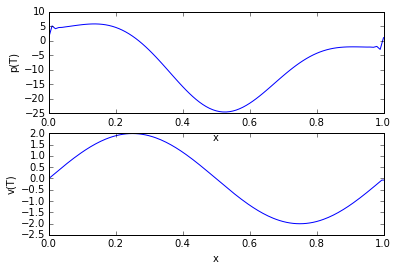

In [9]:
import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(x,pT)
ax1.set_xlabel('x')
ax1.set_ylabel('p(T)')
useTH=True
if not useTH:
    ax2.plot(x,vT[:numerics.nn])
    ax2.set_xlabel('x')
    ax2.set_ylabel('v(T)')
else:
    xm = np.array(0.5*(x[:-1]+x[1:]))
    xq=[];
    vq=[];
    pq=[];
    for i in range(numerics.nn-1):
        xq.append(x[i])
        vq.append(vT[i])
#    uq.append(u[i])
        xq.append(xm[i])
        vq.append(vT[numerics.nn+i])
#    uq.append(u[numerics.nn+i])
    xq.append(x[-1])
    vq.append(vT[-1])
#uq.append(u[-1])
#xq = np.concatenate([x,xm])
#xq.append(x1[-1])
#ax1.plot(xq,uq)
    ax2.plot(xq,vq)
    ax2.set_xlabel('x')
    ax2.set_ylabel('v(T)')

In [10]:
ptrue = pex0(ns.modelList[0].levelModelList[-1].mesh.nodeArray,physics.T)
ptrue - pT

array([  0.        ,  -4.01096261,  -2.97334138,  -3.31589444,
        -3.31171012,  -3.42035135,  -3.51331376,  -3.61896761,
        -3.72262404,  -3.82045204,  -3.90517218,  -3.9701053 ,
        -4.00828068,  -4.01286782,  -3.97723994,  -3.89512076,
        -3.7606903 ,  -3.56868119,  -3.31445674,  -2.99407363,
        -2.60433003,  -2.14280122,  -1.60786479,  -0.99871802,
        -0.31538939,   0.4412536 ,   1.26949903,   2.16678659,
         3.12970498,   4.15399115,   5.23453272,   6.36537531,
         7.5397371 ,   8.75003323,   9.98791263,  11.24430973,
        12.50951325,  13.77325353,  15.02480915,  16.25313273,
        17.44699481,  18.59514356,  19.68647729,  20.71022567,
        21.65613497,  22.5146519 ,  23.27710063,  23.9358472 ,
        24.48444598,  24.91776335,  25.2320743 ,  25.42512896,
        25.49618672,  25.44601734,  25.27686912,  24.99240605,
        24.59761632,  24.0986961 ,  23.50291302,  22.81845427,
        22.05426465,  21.2198799 ,  20.32526024,  19.38

Compare to the exact solution, evaluated at the degrees of freedom. Again, only works for $C^0 P^1$ elements

In [11]:
import numpy as np
pex_vals_at_T = pex0(ns.modelList[0].levelModelList[-1].mesh.nodeArray)
vex_vals_at_T = vex0(ns.modelList[0].levelModelList[-1].mesh.nodeArray)
rex_vals_at_T = rofx0(ns.modelList[0].levelModelList[-1].mesh.nodeArray)

TypeError: pex0() takes exactly 2 arguments (1 given)

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1)
ax1.plot(x,pex_vals_at_T)
ax1.set_xlabel('x')
ax1.set_ylabel('p(T) exact') 
ax2.plot(x,vex_vals_at_T)
ax2.set_xlabel('x')
ax2.set_ylabel('v(T) exact')
ax3.plot(x,rex_vals_at_T)
ax3.set_xlabel('x')
ax3.set_ylabel('r(T) exact')

In [ ]:
err_p = p-pex_vals_at_T
err_p *= err_p
err_p *= physics.L[0]*physics.L[1]/(numerics.nn)
L2approx_p = np.sqrt(err_p.sum())
print x.shape,xm.shape

vtrue = 0.0*vT
for i,val in enumerate(np.concatenate((x,xm))):
    vtrue[i] = vex0(np.array([val]))
err_v = vT-vtrue
plt.plot(err_v)
err_v *= err_v
err_v *= physics.L[0]*physics.L[1]/(numerics.nn)
L2approx_v = np.sqrt(err_v.sum())
print "Trapezoidal rule approx at time T=%s for error at dofs for nn=%s is p_l2=%s and v_l2=%s " % (physics.T,numerics.nn,L2approx_p,L2approx_v)